In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
import syndata
import align
import mgplvm
from mgplvm import kernels, rdist, models, training
from mgplvm.manifolds import Torus
from mgplvm.lpriors import Brownian
plt.rcParams.update({'font.size': 22})

mean activity: 0.39552890735669743


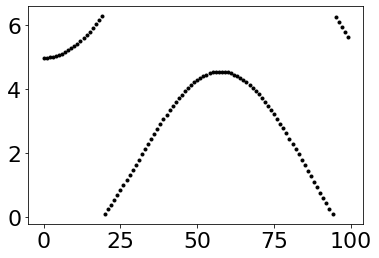

In [9]:
torch.set_default_dtype(torch.float64)
device = mgplvm.utils.get_device("cuda")  # get_device("cpu")

d = 1  # dims of latent space
n = 60 # number of neurons
m = 100 # number of conditions / time points
n_z = 15  # number of inducing points
n_samples = 1  # number of samples
gen = syndata.Gen(syndata.Torus(d), n, m, variability=0.25)
sig0 = 1.5

l = 0.6 #width of the tuning curves
ell = 30 #length scale of the GP from which we draw data
sig_std = 3 #sqrt signal variance of the GP from which we draw data
gen.set_param('l', l)
Y = gen.gen_data(ell = ell, sig = sig_std)
print('mean activity:', np.mean(Y))
plt.figure()
plt.plot(gen.gs[0][:,0], 'k.')
plt.show()

Y = Y + np.random.normal(size=Y.shape) * np.mean(Y) / 3
d = 1
# specify manifold, kernel and rdist
manif = Torus(m, d)
ref_dist = mgplvm.rdist.MVN(m, d, sigma=sig0)
brownian_lprior = Brownian(manif)
# initialize signal variance
alpha = np.mean(np.std(Y, axis=1), axis=1)
kernel = kernels.QuadExp(n, manif.distance, alpha=alpha)
# generate model
sigma = np.mean(np.std(Y, axis=1), axis=1)  # initialize noise
mod = models.Sgp(manif, n, m, n_z, kernel, ref_dist, sigma=sigma, lprior=brownian_lprior).to(device)

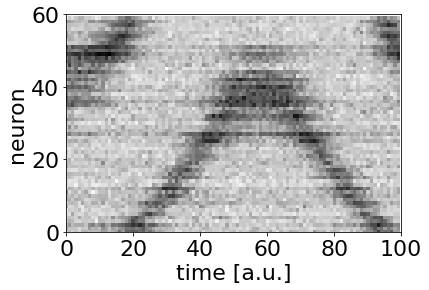

In [10]:
plt.figure()
Yplot = Y[np.argsort(gen.gprefs[0][:,0]), :, 0]
plt.imshow(Yplot, cmap='Greys', aspect='auto')
plt.xlabel("time [a.u.]")
plt.ylabel("neuron")
plt.xlim(0,m)
plt.ylim(0,n)
plt.show()
plt.close()


In [11]:
# train model
trained_mod = training.sgp(Y,
                           mod,
                           device,
                           optimizer=optim.Adam,
                           outdir='none',
                           max_steps=1000,
                           burnin='default',
                           n_b=64,
                           lrate=1E-2,
                           print_every=50)

data = torch.tensor(Y, dtype=torch.get_default_dtype()).to(device)
mod = mod.to(device)
mulearn = mod.manif.prms.data.cpu()
mutrue = gen.gs[0]
plearn = mod.manif.distance(mulearn.T, mulearn.T).numpy()
ptrue = gen.manifold.manifs[0].distance(mutrue, mutrue)
ptrue, plearn = [p.flatten() for p in [ptrue, plearn]]

prms = [p.detach().cpu().numpy() for p in mod.lprior.prms]
print('\nsigma:', np.sqrt(prms[1]), 'c:', prms[0])

iter 1000 | elbo 0.2163 | kl 0.0109 | loss -0.2069 | |mu| 1.6302 | alpha_sqr 0.2605 | ell 1.0980 | sig 0.1009 | brownian_c 0.0078 | brownian_eta 0.03763
sigma: [0.19401154] c: [0.00781933]


final importance weighted log likelihood: 0.2160


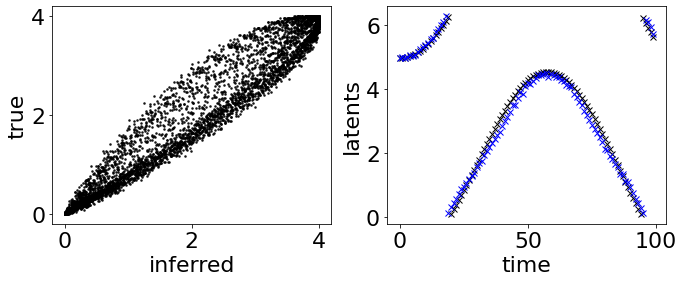

0.006612150208725049 0.1228735805047556
0.007484433142192267 0.1304712531202652


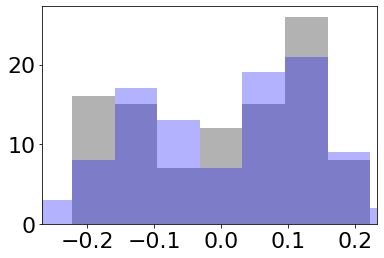

In [12]:
#%% plot pairwise distances

print('final importance weighted log likelihood: %.4f' % mod.calc_LL(data, 128).item())
fig, axs = plt.subplots(1, 2, figsize=(11, 4))
axs[0].plot(plearn, ptrue, "ko", markersize=1.5, alpha=0.5)
axs[0].set_xlabel("inferred")
axs[0].set_ylabel("true")
axs[0].set_xticks((0, 2, 4))
axs[0].set_yticks((0, 2, 4))

i_align = 0 #simple alignment to the first datapoint
mulearn = (mulearn + mutrue[i_align,0] - mulearn[i_align,0] + 20*np.pi ) % (2*np.pi)

#%% plot true and inferred latents
axs[1].plot(mutrue[:, 0], 'kx')
axs[1].plot(mulearn[:, 0], 'bx')
plt.xlabel('time')
plt.ylabel('latents')
plt.show()

#%% look at distances between datapoints
bins = np.linspace(-np.pi, np.pi, 100)
plt.figure()
for i, latents in enumerate([mutrue[:,0], mulearn[:, 0]]):
    diffs = latents[1:] - latents[:-1]
    diffs[diffs > np.pi] -= 2*np.pi
    diffs[diffs < -np.pi] += 2*np.pi
    plt.hist(diffs, bins, color = ['k', 'b'][i], alpha = 0.3)
    print(np.nanmean(diffs), np.nanstd(diffs))
plt.xlim([np.nanmin(diffs), np.nanmax(diffs)])
plt.show()

In [13]:
#align model to ground truth
mod = align.align_torus(mod, gen.gs[0])

# %% compute mse
query = mod.manif.mu.detach()
fmean, fstd = mod.predict(data, query, niter=100)
var = np.mean(np.var(Y, axis=1))
MSE = np.mean(((fmean - data)**2).cpu().numpy())
print('MSE:', MSE, 'var:', var)

coordinate system: [[-1]] 0 loss: 1.8066618315661793
coordinate system: [[-1]] 1 loss: 1.8066618317169294
coordinate system: [[-1]] 2 loss: 1.8066618315661702
coordinate system: [[-1]] 3 loss: 1.80666183156617
coordinate system: [[-1]] 4 loss: 1.8066618315661858
coordinate system: [[1]] 0 loss: 0.027225391442804652
coordinate system: [[1]] 1 loss: 0.027225391442810887
coordinate system: [[1]] 2 loss: 0.02722539144408511
coordinate system: [[1]] 3 loss: 0.027225391443142507
coordinate system: [[1]] 4 loss: 0.0272253916372423
MSE: 0.02521548585201259 var: 0.13463938753423935


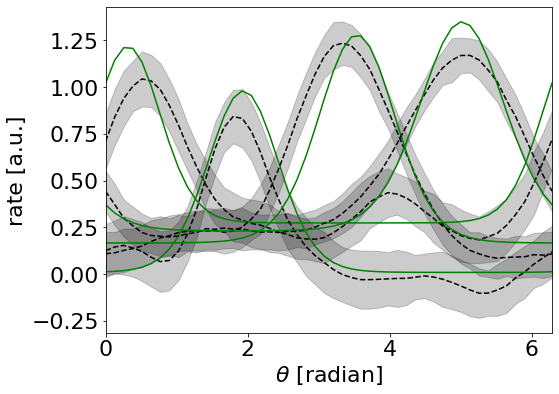

In [14]:
#%% consider 'tuning curves'
query = torch.tensor(np.linspace(0, 2 * np.pi, 50),
                     dtype=torch.get_default_dtype(),
                     device=device)

fmean, fstd = mod.predict(data, query, niter=100)
inds = [np.argmin((gen.gprefs[0] - val)**2) for val in 0.5 + np.arange(4) * 1.5]
plt.figure(figsize=(8, 6))

for i in inds:
    xs, m, std = [arr.cpu().numpy() for arr in [query, fmean, fstd]]
    m, std = [arr[i, :, 0] for arr in [m, std]]
    plt.plot(xs, m, "k--")
    plt.fill_between(xs, m - 2 * std, m + 2 * std, color='k', alpha=0.2)
    true_y = gen.gen_data(gs_in=[xs.reshape(-1, 1)], sigma=np.zeros((mod.n, 1)))
    plt.plot(xs, true_y[i, :, 0], 'g-')

plt.xlabel(r"$\theta$ [radian]")
plt.ylabel(r"rate [a.u.]")
plt.xlim(0, 2 * np.pi)
plt.show()
plt.close()